In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy import dtype, ndarray, float16, int8
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Perceptron Class

In [23]:
class Perceptron:
    def __init__(self, learning_rate: float = 0.1, n_iterations: int = 50):
        """
        Inicjalizacja perceptronu.

        Parametry:
        - learning_rate: Współczynnik uczenia (domyślnie 0.1).
        - n_iterations: Liczba iteracji treningowych (domyślnie 50).
        """
        self.learning_rate = learning_rate  # Ustawia współczynnik uczenia
        self.n_iterations = n_iterations  # Ustawia liczbę iteracji

    def train(self, X: ndarray, y: ndarray):
        """
        Uczenie perceptronu na podstawie danych treningowych.

        Parametry:
        - X: Macierz cech danych treningowych.
        - y: Wektor etykiet klas danych treningowych.
        """
        self.weights = np.zeros(X.shape[1] + 1)  # Inicjalizuje wagi
        for _ in range(self.n_iterations):  # Pętla ucząca
            for xi, target in zip(X, y):  # Pętla po danych treningowych
                prediction = self.predict(xi)  # Przewiduje klasę
                error = target - prediction  # Oblicza błąd
                self.weights[1:] += (
                    self.learning_rate * error * xi
                )  # Aktualizuje wagi cech
                self.weights[0] += self.learning_rate * error  # Aktualizuje bias

    def predict(self, X: ndarray) -> int:
        """
        Przewidywanie etykiety klasowej dla danych wejściowych.

        Parametry:
        - X: Dane wejściowe.

        Zwraca:
        - Wektor etykiet klasowych dla danych wejściowych.
        """
        activation = np.dot(X, self.weights[1:]) + self.weights[0]  # Oblicza aktywację
        return np.where(activation >= 0, 1, -1)  # Zwraca etykiety klas

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        """
        Obliczenie dokładności klasyfikacji na podstawie danych wejściowych i prawdziwych etykiet.

        Parametry:
        - X: Dane wejściowe.
        - y: Prawdziwe etykiety klasowe.

        Zwraca:
        - Dokładność klasyfikacji jako ułamek.
        """
        predictions = self.predict(X)  # Przewiduje etykiety klas
        correct: int = np.sum(predictions == y)  # Liczy poprawne przewidywania
        total = len(y)  # Liczy łączną liczbę próbek
        return correct / total  # Zwraca dokładność klasyfikacji

### Plotting the decision boundary

In [24]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    Rysowanie regionów decyzyjnych klasyfikatora.

    Parametry:
    - X: Macierz cech danych.
    - y: Wektor etykiet klas danych.
    - classifier: Obiekt klasyfikatora z metodami fit i predict.
    - resolution: Rozdzielczość siatki.
    """
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Tworzenie siatki punktów do pokolorowania
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Rysowanie próbek klasy
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f'Class {cl}', edgecolor='black')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.show()

## Data

In [25]:
def generate_data(seed: int = None) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
    """
    Generating 2D points divided into 4 clusters.

    Parameters:
    - seed: Random seed for data generation.

    Returns:
    - Tuple containing X (data) and y (labels).
    """
    np.random.seed(seed)
    X: ndarray[float16, dtype[float16]] = np.vstack(
        [
            np.random.normal(loc=[1, 10], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[10, 1], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[1, 1], scale=[1, 1], size=(50, 2)),
            np.random.normal(loc=[10, 10], scale=[1, 1], size=(50, 2)),
        ]
    )
    y: ndarray[int8, dtype[int8]] = np.array([0] * 50 + [1] * 50 + [2] * 50 + [3] * 50)

    return (X, y)

In [26]:
def split_data(X: ndarray, y: ndarray) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
    indices = np.random.permutation(len(X))
    split = int(0.8 * len(X))
    X_train, X_test = (
        X[indices[:split]],
        X[indices[split:]],
    )
    y_train, y_test = (
        y[indices[:split]],
        y[indices[split:]],
    )
    return (X_train, y_train, X_test, y_test)

In [27]:
X, y = generate_data()
X_train, y_train, X_test, y_test = split_data(X, y)

## One Versus the Rest

In [28]:
class OneVersusTheRest:
    def __init__(self, y: ndarray):

        self.perceptrons: List[Perceptron] = [
            Perceptron() for _ in range(len(np.unique(y)))
        ]

    def train(self, X_train: ndarray, y_train: ndarray):
        for i, perceptron in enumerate(self.perceptrons):
            y_train_perceptron = np.where(y_train == i, 1, -1)
            perceptron.train(X_train, y_train_perceptron)

    def predict(self, X_test: ndarray) -> int:
        predictions = np.array(
            [perceptron.predict(X_test) for perceptron in self.perceptrons]
        )
        return np.argmax(predictions, axis=0)

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        predictions = self.predict(X)
        correct: int = np.sum(predictions == y)
        total = len(y)
        return correct / total

### Wizualization for the One Versus the Rest (OVR) strategy.

Accuracy: 1.0


C:\Users\Olek Zima\AppData\Local\Temp\ipykernel_23932\130806838.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


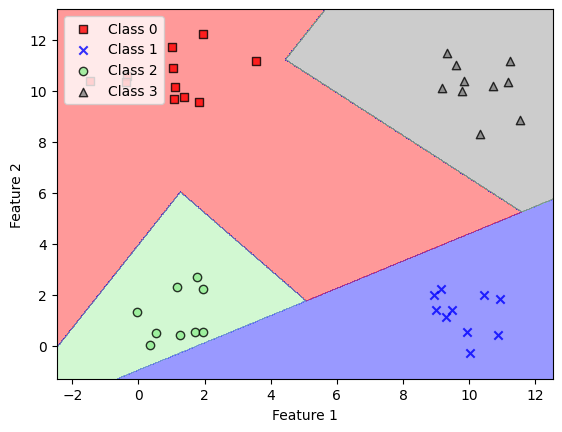

In [29]:
ovr = OneVersusTheRest(y)
ovr.train(X_train, y_train)
print(f"Accuracy: {ovr.accuracy(X_test, y_test)}")

plot_decision_regions(X_test, y_test, ovr)

## One Versus One

In [30]:
from itertools import combinations

class OneVersusOne:
    def __init__(self, base_classifier, n_classes: int):
        """
        Inicjalizacja klasyfikatora One vs One.

        Parametry:
        - base_classifier: klasa klasyfikatora bazowego, np. Perceptron.
        - n_classes: liczba różnych klas w danych.
        """
        self.base_classifier = base_classifier
        self.n_classes = n_classes
        self.classifiers = []  # Lista klasyfikatorów dla każdej pary klas

    def train(self, X: np.ndarray, y: np.ndarray):
        """
        Trenowanie klasyfikatorów dla każdej pary klas.

        Parametry:
        - X: Macierz cech danych treningowych.
        - y: Wektor etykiet klas danych treningowych.
        """
        for class_pair in combinations(range(self.n_classes), 2):
            # Tworzenie maski dla obecnej pary klas
            mask = np.logical_or(y == class_pair[0], y == class_pair[1])
            X_pair = X[mask]
            y_pair = y[mask]
            # Przypisanie etykiet -1 i 1 dla klasyfikacji binarnej
            y_pair_binary = np.where(y_pair == class_pair[0], -1, 1)
            # Inicjalizacja i trenowanie klasyfikatora dla obecnej pary
            classifier = self.base_classifier()
            classifier.train(X_pair, y_pair_binary)
            self.classifiers.append((classifier, class_pair))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Przewidywanie etykiet klasowych dla danych wejściowych.

        Parametry:
        - X: Dane wejściowe.

        Zwraca:
        - Wektor przewidywanych etykiet klasowych.
        """
        predictions = np.zeros((X.shape[0], self.n_classes))
        for classifier, classes in self.classifiers:
            prediction = classifier.predict(X)
            # Głosowanie: inkrementacja licznika dla wybranej klasy
            for i, p in enumerate(prediction):
                if p == 1:
                    predictions[i, classes[1]] += 1
                else:
                    predictions[i, classes[0]] += 1
        # Zwraca klasy z największą liczbą głosów
        return np.argmax(predictions, axis=1)

    def accuracy(self, X: ndarray, y: ndarray) -> float:
        predictions = self.predict(X)
        correct: int = np.sum(predictions == y)
        total = len(y)
        return correct / total

### Wizualization for the One Versus One (OVO) strategy.

Accuracy: 1.0


C:\Users\Olek Zima\AppData\Local\Temp\ipykernel_23932\130806838.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


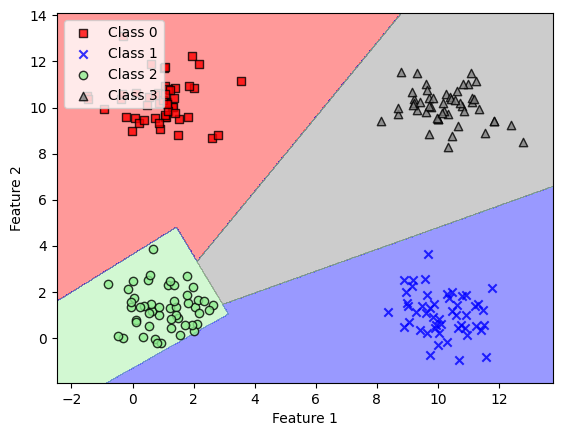

In [34]:
ovo = OneVersusOne(Perceptron, 4)
ovo.train(X_train, y_train)
print(f"Accuracy: {ovo.accuracy(X_test, y_test)}")

plot_decision_regions(X_test, y_test, ovo)